In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
a2015003713_distilberttextaugmadgrad5folds_path = kagglehub.dataset_download('a2015003713/distilberttextaugmadgrad5folds')
a2015003713_joint_f0gem3420768_dbert_highway_path = kagglehub.dataset_download('a2015003713/joint-f0gem3420768-dbert-highway')
a2015003713_timm_shpee_path = kagglehub.dataset_download('a2015003713/timm-shpee')
# a2015003713_shop = kagglehub.dataset_download("a2015003713/shopee-price-match-guarantee")

print('Data source import complete.')


Using Colab cache for faster access to the 'distilberttextaugmadgrad5folds' dataset.
Using Colab cache for faster access to the 'joint-f0gem3420768-dbert-highway' dataset.
Using Colab cache for faster access to the 'timm-shpee' dataset.
Data source import complete.


In [ ]:
# Проверьте текущую настройку Kaggle
import os

print("🔍 Проверка Kaggle конфигурации:")
print(f"1. HOME: {os.environ.get('HOME')}")
print(f"2. KAGGLE_CONFIG_DIR: {os.environ.get('KAGGLE_CONFIG_DIR')}")
print(f"3. KAGGLE_KEY: {'✅ Есть' if os.environ.get('KAGGLE_KEY') else '❌ Нет'}")

# Проверьте существующие файлы
import glob
print("\n📁 Поиск kaggle.json:")
for path in ['/root/.kaggle', '/root/.config/kaggle', '~/.kaggle', '~/.config/kaggle']:
    expanded = os.path.expanduser(path)
    if os.path.exists(expanded):
        files = glob.glob(os.path.join(expanded, 'kaggle.json'))
        if files:
            print(f"✅ Найден в {files[0]}")
        else:
            print(f"📁 Папка есть, но нет kaggle.json: {expanded}")

# Создайте правильную структуру
def setup_kaggle_correctly():
    """Правильная настройка Kaggle API"""
    import json

    # Вариант 1: /root/.kaggle/kaggle.json
    path1 = '/root/.kaggle/kaggle.json'
    os.makedirs(os.path.dirname(path1), exist_ok=True)

    # Вариант 2: /root/.config/kaggle/kaggle.json
    path2 = '/root/.config/kaggle/kaggle.json'
    os.makedirs(os.path.dirname(path2), exist_ok=True)

    # Ваш токен
    config = {
        "username": "your_username_here",  # ⬅️ НУЖНО УКАЗАТЬ ВАШ USERNAME!
        "key": "KGAT_c7c57f62b44fcd9556effc95169e75bf"
    }

    # Сохраняем в оба места для надежности
    for path in [path1, path2]:
        with open(path, 'w') as f:
            json.dump(config, f)
        os.chmod(path, 0o600)
        print(f"✅ Создан {path}")

    # Устанавливаем переменные окружения
    os.environ['KAGGLE_USERNAME'] = config['username']
    os.environ['KAGGLE_KEY'] = config['key']

    return True

# Запустите настройку
setup_kaggle_correctly()

🔍 Проверка Kaggle конфигурации:
1. HOME: /root
2. KAGGLE_CONFIG_DIR: None
3. KAGGLE_KEY: ❌ Нет

📁 Поиск kaggle.json:
✅ Создан /root/.kaggle/kaggle.json
✅ Создан /root/.config/kaggle/kaggle.json


True

In [ ]:
!ls

sample_data


In [ ]:
# === СКАЧИВАНИЕ КОНКУРСА SHOPEE ===
import os

os.environ['KAGGLE_API_TOKEN'] = 'KGAT_c7c57f62b44fcd9556effc95169e75bf'


# Скачиваем данные конкурса
!kaggle competitions download -c shopee-product-matching

!unzip -q shopee-product-matching.zip -d shopee_data

 98% 1.66G/1.68G [01:40<00:04, 6.54MB/s]
100% 1.68G/1.68G [01:40<00:00, 18.0MB/s]


In [ ]:
# !unzip -q shopee-product-matching.zip -d shopee_data

replace shopee_data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shopee_data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shopee_data/test_images/0006c8e5462ae52167402bac1c2e916e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shopee_data/test_images/0007585c4d0f932859339129f709bfdc.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shopee_data/test_images/0008377d3662e83ef44e1881af38b879.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shopee_data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shopee_data/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shopee_data/train_images/00039780dfc94d01db8676fe789ecd05.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import numpy as np
import pandas as pd
import collections
import gc
from tqdm import tqdm
import cv2
import cudf, cuml, cupy
from cuml.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,  random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import transformers
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig


import sys
sys.path.append('../kaggle/input/timm-shpee/pytorch-image-models-master')
import timm
from timm.models.layers import SelectAdaptivePool2d

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
cos_threshs = np.array([0.16])
test_batch_size = 128

# image model
GEM_P = 4
image_size = 420

# TTA for image(do not use)
flip_TTAs = [False, False, False, False, False]
testing_scales = [[1.0], [1.0], [1.0], [1.0], [1.0]]

# text model
text_max_length = 84

# alpha query expansion
alpha_query_expansion = True
qe_mid_knn = True
qe_ms     = [[1, 1], [1, 1], [1, 1], [2, 1], [1, 1]]
qe_alphas = [[2, 5], [2, 7], [5, 2], [7, 2], [3, 3]]

# adaptive thresholding
USE_ADAPTIVE_THRESHOLDING = False
CONSERVATIVENESS = 1.0
BETA = np.mean([0.9, 0.8, 0.9, 0.75, 0.3])

# min num preds
force_2preds = True
force_2preds_relax = 1.2

# kNN
KNN = 52
ALPHA_QE_KNN = 8
knn_metric = 'cosine' # cosine or correlation

In [3]:
ls ../kaggle/input

distilberttextaugmadgrad5folds/  joint-f0gem3420768-dbert-highway/  timm-shpee/


In [4]:
# model_weight_paths = [
#     '../kaggle/input/joint-f0gem3420768-dbert-highway/Joint_F0GeM3-420-768Emb-1024XBM_DBERT-Aug0.1_XBM4096_fold0_HighwayConc768x3_ep-002_f1-0.88579_thresh-0.43448_bs-30_emb-2304.pth',
#     '../kaggle/input/joint-f0gem3420768-dbert-highway/Joint_F0GeM3-420-768Emb-1024XBM_DBERT-Aug0.1_XBM4096_fold1_HighwayConc768x3_ep-002_f1-0.89122_thresh-0.42069_bs-32_emb-2304.pth',
#     '../kaggle/input/joint-f0gem3420768-dbert-highway/Joint_F0GeM3-420-768Emb-1024XBM_DBERT-Aug0.1_XBM4096_fold2_HighwayConc768x3_ep-003_f1-0.88911_thresh-0.44828_bs-30_emb-2304.pth',
#     '../kaggle/input/joint-f0gem3420768-dbert-highway/Joint_F0GeM3-420-768Emb-1024XBM_DBERT-Aug0.1_XBM4096_fold3_HighwayConc768x3_ep-002_f1-0.88196_thresh-0.44828_bs-32_emb-2304.pth',
#     '../kaggle/input/joint-f0gem3420768-dbert-highway/Joint_F0GeM3-420-768Emb-1024XBM_DBERT-Aug0.1_XBM4096_fold4_HighwayConc768x3_ep-003_f1-0.88931_thresh-0.44828_bs-32_emb-2304.pth'
#                      ]
# tokenizer = DistilBertTokenizer.from_pretrained('../kaggle/input/distilberttextaugmadgrad5folds/distil-bert-textaug-madgrad-5folds/tokenizer')


# # general
# loader_num_workers = 2
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [65]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

vocab.txt: 0.00B [00:00, ?B/s]

In [4]:
# tokenizer = DistilBertTokenizer.from_pretrained('../kaggle/input/distilberttextaugmadgrad5folds/distil-bert-textaug-madgrad-5folds/tokenizer')



In [66]:
# general
loader_num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# load data

In [67]:
ls shopee_data/

sample_submission.csv  test.csv  test_images/  train.csv  train_images/


In [68]:
test = pd.read_csv('shopee_data/train.csv')
# else:
#     test = pd.read_csv('shopee_data/test.csv')
# test = test.drop(columns='image_phash')

LEN_TEST = len(test)

# BASE = 'shopee_data/test_images/'
# if COMPUTE_CV:
#     BASE = 'shopee_data/train_images/'


BASE = 'shopee_data/train_images/'

CHUNK = 1024*4
CTS = LEN_TEST//CHUNK
if LEN_TEST%CHUNK!=0:
    CTS += 1

if LEN_TEST==3:
    KNN = 3
    ALPHA_QE_KNN = 3
    qe_ms     = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]
    qe_alphas = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]

# dataset

In [69]:
df = pd.read_csv('shopee_data/train.csv')

In [70]:
df.shape

(34250, 5)

In [71]:
ddd = df.label_group.value_counts().reset_index()

In [72]:
no_labels = ddd[ddd['count'] <= 3].label_group.unique()

In [73]:
len(no_labels)

8758

In [74]:
df = df[~df['label_group'].isin(no_labels)]

In [75]:
df.shape

(14955, 5)

In [76]:
# tokenize titles
texts = list(df['title'].apply(lambda o: str(o)).values)
text_encodings = tokenizer(texts,
                           padding=True,
                           truncation=True,
                           max_length=text_max_length)

df['input_ids'] = text_encodings['input_ids']
df['attention_mask'] = text_encodings['attention_mask']

# del texts, text_encodings, tokenizer
_=gc.collect()

In [77]:
texts[:3]

['Jubah anak size 1-12 thn',
 'Korek Kuping LED untuk balita CherryBabyKidsShop SP LC',
 'Madame Gie MakeUp Blush On BY GISELL']

In [78]:
df[:3]

posting_id                                 image       image_phash  \
6   train_1802986387  00144a49c56599d45354a1c28104c039.jpg  f815c9bb833ab4c8   
15  train_4196427721  002039aaf8618627a0442d5e89e5dda6.jpg  e98c873acc65946e   
19  train_2961381387  00303ad1c062fdeaf5f41b9ffb71a5fb.jpg  e48d9b652098efe1   

                                                title  label_group  \
6                            Jubah anak size 1-12 thn   1835033137   
15  Korek Kuping LED untuk balita CherryBabyKidsSh...    349297863   
19               Madame Gie MakeUp Blush On BY GISELL   2098400894   

                                            input_ids  \
6   [101, 18414, 24206, 9617, 2243, 2946, 1015, 10...   
15  [101, 12849, 16816, 13970, 4691, 2419, 4895, 8...   
19  [101, 10602, 21025, 2063, 5789, 16688, 2006, 2...   

                                       attention_mask  
6   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...  
15  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
19  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...

In [79]:
# # папка для хранения инфы о моделях
# from google.colab import drive
# drive.mount('/content/drive')

In [80]:
df.label_group.value_counts()[:2]

label_group
1141798720    51
562358068     51
Name: count, dtype: int64

In [81]:
class Shopee(Dataset):
    def __init__(self, df, image_dir, augs):
        self.df = df
        self.augs = augs
        self.image_dir = image_dir


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {'input_ids': torch.tensor(self.df['input_ids'].iloc[idx]), 'attention_mask': torch.tensor(self.df['attention_mask'].iloc[idx])}

        # image
        image = cv2.imread(self.image_dir + self.df.iloc[idx]['image']).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.augs(image=image)['image']

        target = {'target': torch.tensor(self.df['label_group'].iloc[idx])}

        return image, item, target

def make_aug(scale=1.0, horizontal_flip=False):
    im_size = int(round(scale*image_size))
    if horizontal_flip:
        valid_aug = A.Compose([A.LongestMaxSize(max_size=im_size, p=1),
                               A.PadIfNeeded(min_height=im_size, min_width=im_size, border_mode=0, p=0.5),
                               A.HorizontalFlip(p=0.5),
                               A.Normalize(p=1.0),
                               ToTensorV2(p=1.0)])

    else:
        valid_aug = A.Compose([A.LongestMaxSize(max_size=im_size, p=1.0),
                               A.PadIfNeeded(min_height=im_size, min_width=im_size, border_mode=0, p=1.0),
                               A.Normalize(p=1.0),
                               ToTensorV2(p=1.0)])

    return valid_aug

In [82]:
im_size = 420

In [83]:
# Тренировка:
train_aug = A.Compose([
    A.LongestMaxSize(max_size=im_size, p=1.0),  # ВСЕГДА
    A.PadIfNeeded(min_height=im_size, min_width=im_size, border_mode=0, p=1.0),  # ВСЕГДА
    A.HorizontalFlip(p=0.5),  # 50% вероятность
    A.Normalize(p=1.0),  # ВСЕГДА
    ToTensorV2(p=1.0)  # ВСЕГДА
])

# Валидация:
val_aug = A.Compose([
    A.LongestMaxSize(max_size=im_size, p=1.0),  # ВСЕГДА
    A.PadIfNeeded(min_height=im_size, min_width=im_size, border_mode=0, p=1.0),  # ВСЕГДА
    A.Normalize(p=1.0),  # ВСЕГДА
    ToTensorV2(p=1.0)  # ВСЕГДА
    # НЕТ HorizontalFlip!
])

In [84]:
train_size = int(len(df.label_group.unique())*0.8)
train_labels = df.label_group.unique()[:train_size]
val_labels = df.label_group.unique()[train_size:]

df_train = df[df['label_group'].isin(train_labels)]

df_test = df[df['label_group'].isin(val_labels)]

In [85]:
# Создаем датасет
train_dataset = Shopee(df_train, image_dir='shopee_data/train_images/', augs=train_aug)

test_dataset = Shopee(df_test, image_dir='shopee_data/train_images/', augs=val_aug)

In [86]:
df_train.shape

(12670, 7)

In [87]:
df_test.shape

(2285, 7)

In [88]:
train_dataset

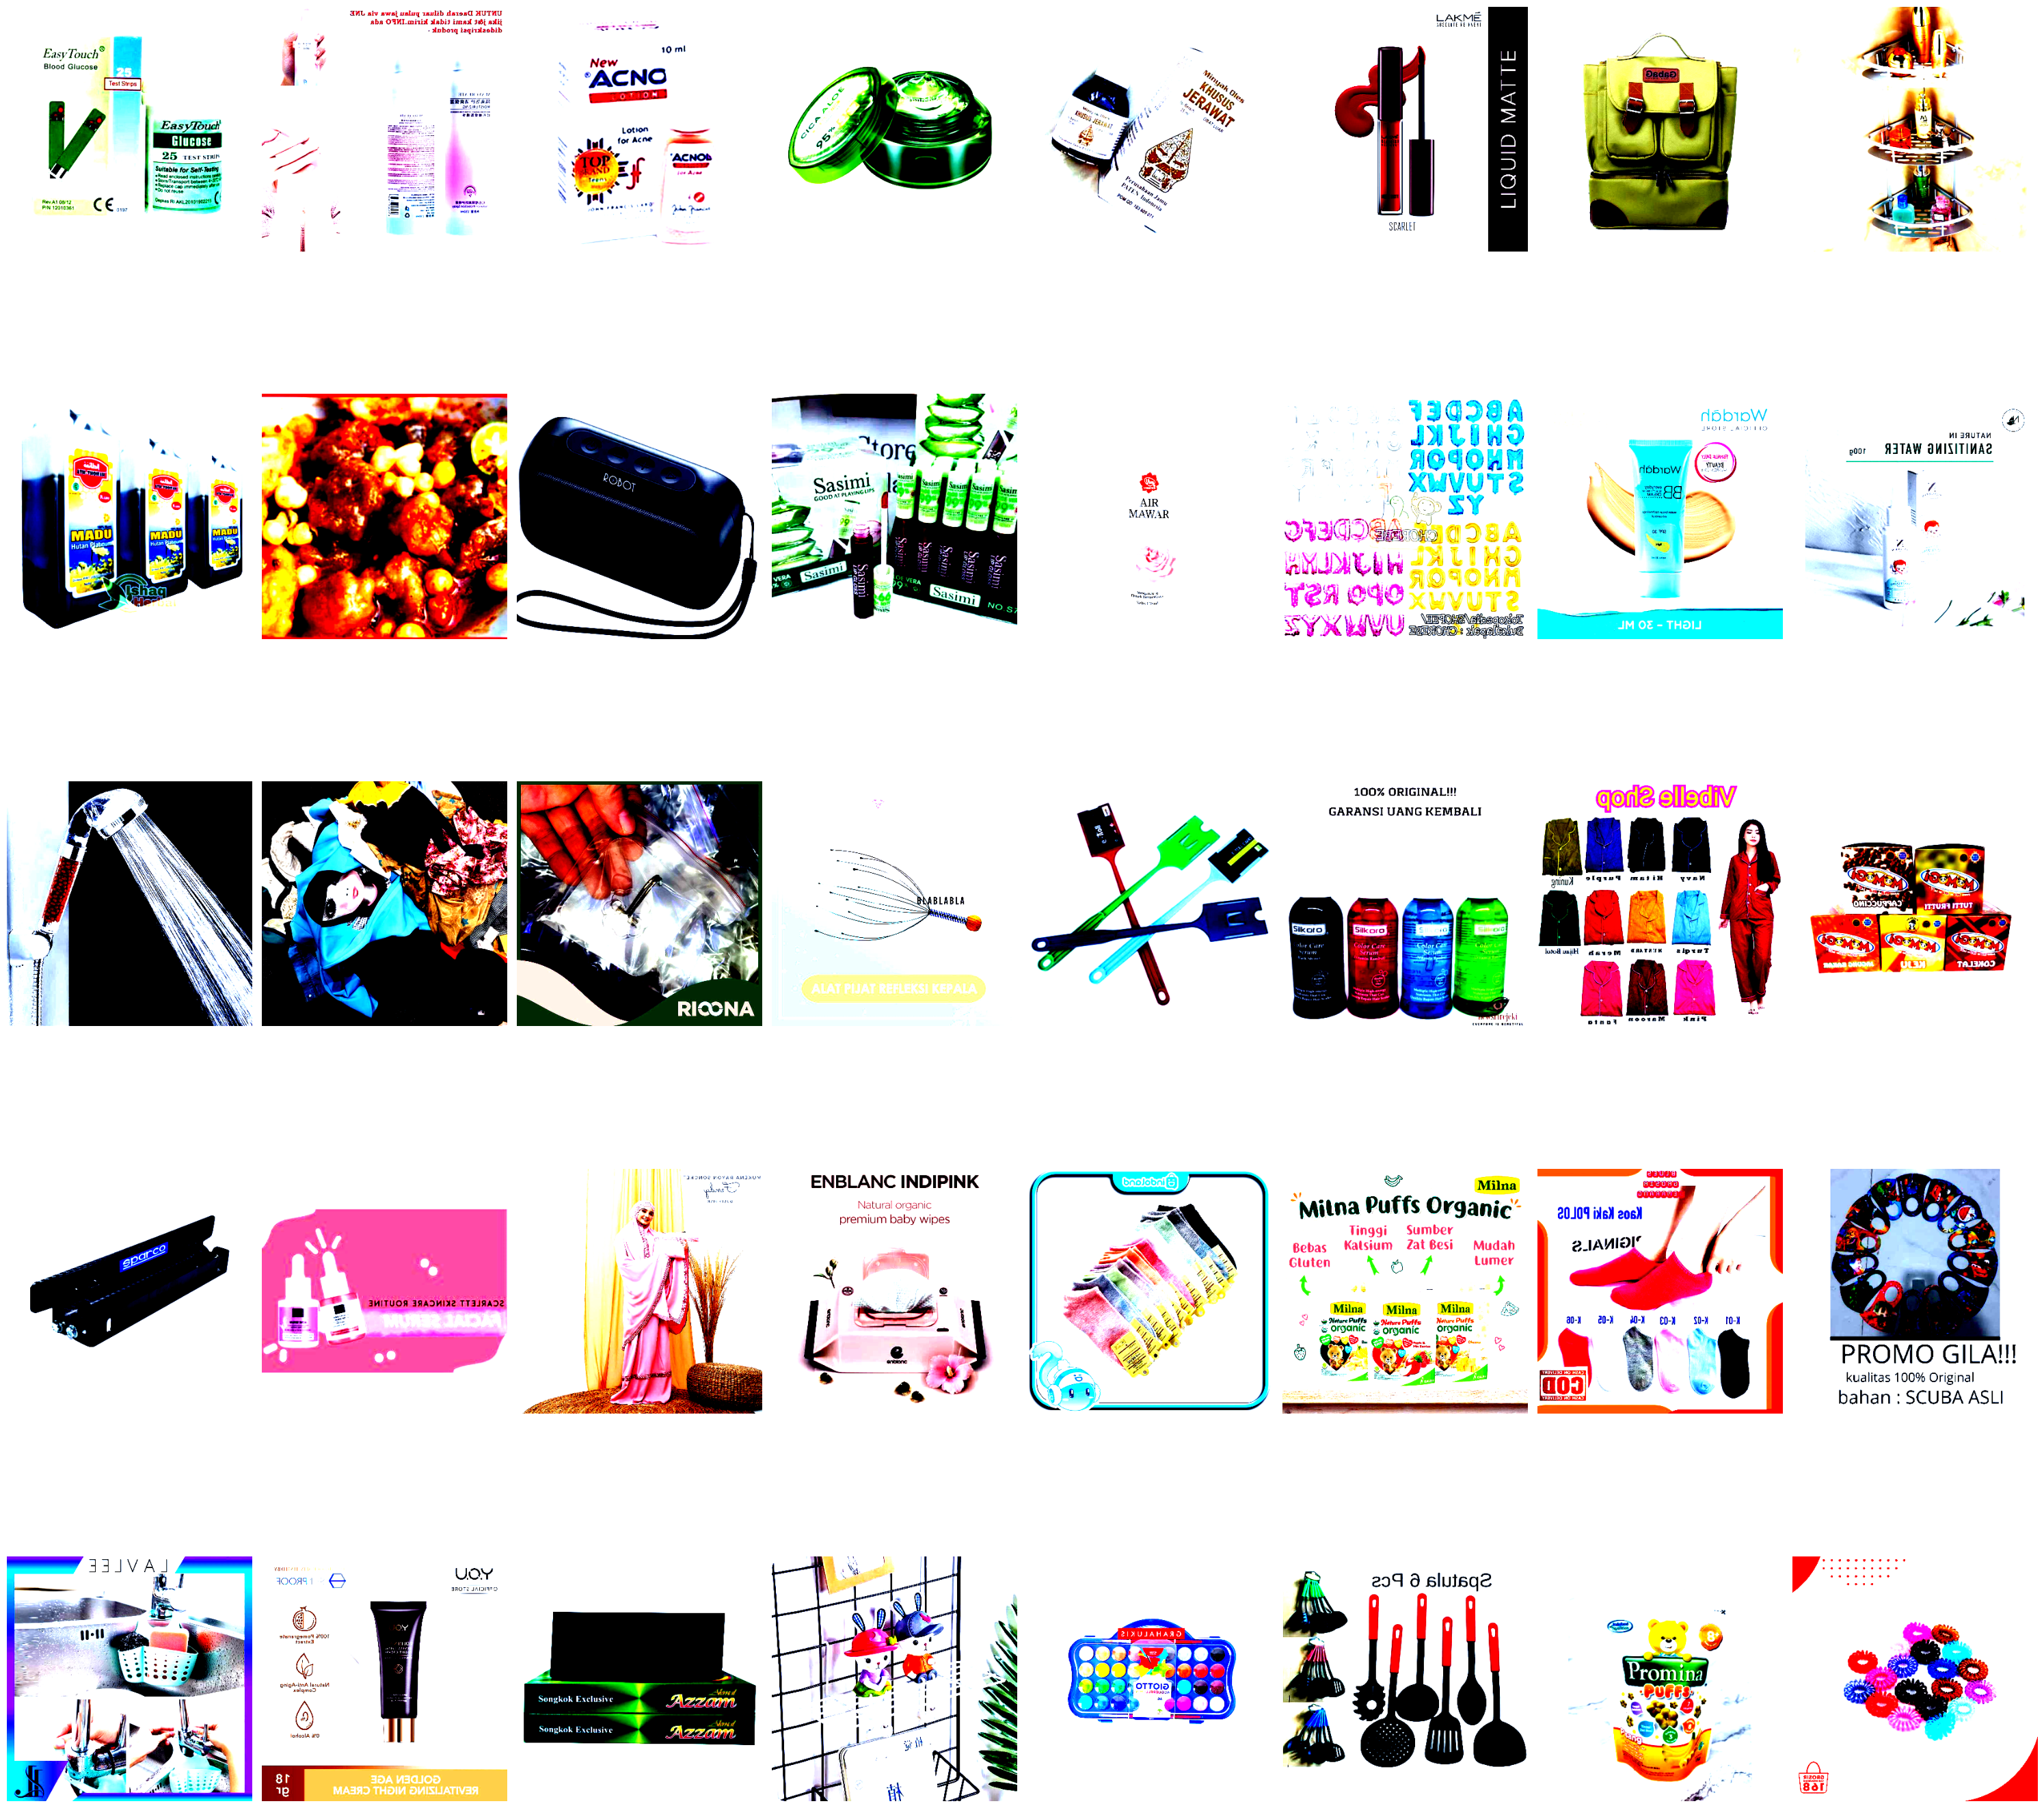

In [89]:
import matplotlib.pyplot as plt

indices = torch.randperm(len(train_dataset))[:40]

fig, axes = plt.subplots(5, 8, figsize=(30, 30))

for i, ax in enumerate(axes.flat):
    image = train_dataset[int(indices[i])][0]

    image = image.permute(1, 2, 0).cpu().numpy()

    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [90]:
df_train.label_group.value_counts()

label_group
1141798720    51
562358068     51
994676122     51
3627744656    51
3113678103    51
              ..
750079332      4
553594330      4
2935245097     4
2262691189     4
4094408277     4
Name: count, Length: 1804, dtype: int64

In [91]:
df_train.label_group.nunique()

1804

In [92]:
df_train.shape

(12670, 7)

In [93]:
df_train.label_group.nunique()/128

14.09375

In [94]:
import numpy as np
from torch.utils.data import Sampler

class PKSampler(Sampler):
    """Минимальная рабочая версия PK-Sampler"""
    def __init__(self, labels, P, K):
        self.P = P
        self.K = K
        self.batch_size = P * K

        # Группируем индексы
        self.class_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

        # Оставляем только классы с ≥K примерами
        self.valid_classes = [c for c, idxs in self.class_indices.items()
                             if len(idxs) >= K]

        # Считаем батчи
        self.n_batches = sum(len(idxs) for c, idxs in self.class_indices.items()
                           if c in self.valid_classes) // self.batch_size

        print(f"SimplePKSampler: {len(self.valid_classes)} классов, {self.n_batches} батчей")

    def __iter__(self):
        for _ in range(self.n_batches):
            batch = []
            # Выбираем P классов
            classes = np.random.choice(self.valid_classes, self.P, replace=False)
            for cls in classes:
                # Выбираем K примеров
                indices = self.class_indices[cls]
                selected = np.random.choice(indices, self.K, replace=False)
                batch.extend(selected)
            yield batch

    def __len__(self):
        return self.n_batches


# Использование:
labels = df_train.label_group.values  # список меток для всего датасета
sampler = PKSampler(labels, P=16, K=4)


SimplePKSampler: 1804 классов, 197 батчей


In [95]:
len(labels)

12670

In [96]:
batch_size = 128

num_workers = 4
prefetch_factor = 2
persistent_workers = True

train_loader = DataLoader(
    train_dataset,
    batch_sampler=sampler,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)


val_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

# model

In [117]:
# J3 without joint embeddings(stacked embeddings)
# joint embeddings give no score(CV and LB) boost, image/text concat embeddings are sufficient
class AdaptiveGeneralizedMeanPool2d(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(AdaptiveGeneralizedMeanPool2d, self).__init__()
        self.p = p
        self.eps = eps
        self.flatten1 = nn.Flatten()

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        x = F.adaptive_avg_pool2d(input=x.clamp(min=eps).pow(p), output_size=(1, 1)).pow(1./p)
        x = self.flatten1(x)
        return x


# заменил dm_nfnet_f0 на mobilenetv3_small_100
class SimpleMobileNetV3(nn.Module):
    def __init__(self, embedding_size=256, pretrained=True):
        super().__init__()

        # MobileNetV3 без финальных слоев
        self.backbone = timm.create_model(
            'mobilenetv3_small_100',
            pretrained=pretrained,
            num_classes=0,      # Нет classifier
            global_pool='',     # Нет pooling
        )

        # GeM pooling
        self.gem_pool = nn.Sequential(
            AdaptiveGeneralizedMeanPool2d(p=3),
            nn.Flatten()
        )
        # Эмбеддинг слой (576 → embedding_size)
        self.fc = nn.Linear(576, embedding_size)

    def forward(self, x):
        # Conv фичи
        x = self.backbone.forward_features(x)  # [batch, 576, 7, 7]

        # GeM pooling
        x = self.gem_pool(x)  # [batch, 576]

        # Эмбеддинг
        x = self.fc(x)  # [batch, embedding_size]

        # Нормализация
        x = F.normalize(x, p=2, dim=1)

        return x

class DistilBERT_L2(nn.Module):
    def __init__(self, bert_model):
        super(DistilBERT_L2, self).__init__()
        self.bert_model = bert_model

    def forward(self, batch):
        output = self.bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        last_hidden_state = output.last_hidden_state
        CLS_token_state = last_hidden_state[:, 0, :]
        CLS_token_state = F.normalize(CLS_token_state, p=2, dim=1, eps=1e-12)

        return CLS_token_state


class JointModel(nn.Module):
    def __init__(self, text_model, image_model):
        super(JointModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model

        # define fc1(embeddings stacking), this won't be used for forward
        image_emb_size = 256  # из SimpleMobileNetV3
        text_emb_size = 256   # из DistilBERT_L2
        concat_size = image_emb_size + text_emb_size  # 512

        hidden_size = 512

        # Проекционная голова с BatchNorm и Dropout
        # self.projection = nn.Sequential(
        #     nn.Linear(concat_size, hidden_size),
        #     nn.BatchNorm1d(hidden_size),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(hidden_size, concat_size)
        # )



    def forward(self, image_input, batch):
        # image embeddings
        image_emb = self.image_model(image_input)

        # CLS_token as text embeddings
        text_emb = self.text_model(batch)

        x = torch.cat((image_emb, text_emb), dim=1)

        # x = self.projection(x)

        x = F.normalize(x, p=2, dim=1)

        return x

In [118]:
from transformers import AutoModel

class TinyBERTWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        # Очень маленький но предобученный
        self.bert = AutoModel.from_pretrained('prajjwal1/bert-tiny')

        # Замораживаем
        # for param in self.bert.parameters():
        #     param.requires_grad = False

        # Проекция
        self.projection = nn.Linear(128, 256)

    def forward(self, batch):
        with torch.no_grad():
            output = self.bert(**batch)

        # CLS token
        cls_token = output.last_hidden_state[:, 0, :]  # [batch, 128]
        x = self.projection(cls_token)  # [batch, 64]

        return x

In [121]:
bert = AutoModel.from_pretrained('prajjwal1/bert-tiny')

In [122]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-1): 2 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
image_model = SimpleMobileNetV3(256, False)

In [119]:

class LightButStrongImageModel(nn.Module):
    def __init__(self, embedding_size=256):
        super().__init__()

        # EfficientNet B0 - хороший баланс
        self.backbone = timm.create_model(
            'tf_efficientnet_b0_ns',
            pretrained=True,
            num_classes=0,
            global_pool='',
            features_only=False,
        )

        # Простой pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Компактная проекция
        backbone_out = 1280  # для efficientnet_b0
        self.projection = nn.Sequential(
            nn.Linear(backbone_out, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, embedding_size)
        )

    def forward(self, x):
        features = self.backbone.forward_features(x)
        pooled = self.pool(features).flatten(1)
        embeddings = self.projection(pooled)
        return embeddings  # БЕЗ нормализации

In [120]:
image_model = SimpleMobileNetV3(256, False)

text_model = TinyBERTWrapper()
model = JointModel(text_model, image_model)
del text_model, image_model

_=model.to(device)
_=model.eval()

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [52]:
# image_model = SimpleMobileNetV3(256, False)
# bert_config = DistilBertConfig(activation='gelu',
#                                attention_dropout=0.1,
#                                dim=256, #  768
#                                dropout=0.1,
#                                hidden_dim=512, #  3072
#                                initializer_range=0.02,
#                                max_position_embeddings=512,
#                                model_type='distilbert',
#                                n_heads=4, #  12
#                                n_layers=2,  #  6
#                                output_hidden_states=True,
#                                pad_token_id=0,
#                                qa_dropout=0.1,
#                                seq_classif_dropout=0.2,
#                                sinusoidal_pos_embds=True,
#                                tie_weights_=True,
#                                vocab_size=32000)
# bert_model = DistilBertModel(bert_config)
# text_model = DistilBERT_L2(bert_model)
# model = JointModel(text_model, image_model)
# del bert_model, text_model, image_model

# _=model.to(device)
# _=model.eval()

In [53]:
def joint_embedder(df, model, scale=1.0, flip=False):
    embeds = []
    CHUNK = 1024*4
    for i,j in enumerate(range(CTS)):
        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,len(df))

        test_data = Shopee(df.iloc[a:b].reset_index(drop=True),
                           BASE,
                           augs=make_aug(scale=scale, horizontal_flip=flip))
        test_loader = DataLoader(test_data,
                                 shuffle=False,
                                 num_workers=loader_num_workers,
                                 pin_memory=False,# False:faster
                                 batch_size=test_batch_size)
        with torch.no_grad():
            for inputs, batch in tqdm(test_loader):
                batch = {k: v.to(device) for k, v in batch.items()}
                inputs = inputs.to(device)
                embedding = model(inputs, batch).detach().cpu().numpy()
                embeds.append(embedding)

    return np.concatenate(embeds)


def distance_to_matching_probability(x):
    # fit distance to matching probability by poly-lines
    p1 = [0.2, 0.850*CONSERVATIVENESS]
    p2 = [0.3, 0.600*CONSERVATIVENESS]
    p3 = [0.4, 0.225*CONSERVATIVENESS]
    p4 = [0.5, 0.050*CONSERVATIVENESS]
    if x < 0.0:
        y = 1.0
    elif x < p1[0]:
        y = x*(p1[1] - 1.0)/(p1[0] - 0.0) + 1.0
    elif x < p2[0]:
        y = (x - p2[0])*(p2[1] - p1[1])/(p2[0] - p1[0]) + p2[1]
    elif x < p3[0]:
        y = (x - p3[0])*(p3[1] - p2[1])/(p3[0] - p2[0]) + p3[1]
    elif x < p4[0]:
        y = (x - p4[0])*(p4[1] - p3[1])/(p4[0] - p3[0]) + p4[1]
    elif x < 0.6:
        y = (x - 0.6)*(0.0 - p4[1])/(0.6 - p4[0])
    else:
        y = 0
    return y

def adaptive_thresholding(dists=None, global_thresh=None, beta=None):
    probs = np.frompyfunc(distance_to_matching_probability, 1, 1)(dists)

    # expected number of positives
    ex_num_pos = np.sum(probs > 0.5)

    # expected F1 change when one more prediction is added
    # sign of F1 change matters
    for num_pred in range(0, KNN):
        #denom = (num_pred + 1 + ex_num_pos)*(num_pred + ex_num_pos)
        #term1 = 2.0/denom
        term2 = (num_pred + ex_num_pos)*probs[num_pred] - np.sum(probs[:num_pred])
        #dF = term1*term2
        dF = term2

        if dF < 0:
            break

    best_thresh = dists[num_pred]*1.00001
    best_thresh = 0.5*(best_thresh-0.3)+0.1875
    adaptive_thresh = beta*best_thresh + (1.0 - beta)*global_thresh

    #print(f'{global_thresh}-->{adaptive_thresh}')

    return adaptive_thresh


def knn_matching(knn_model, embeddings, thresh):
    preds = []
    CHUNK = 1024*4

    CTS = len(embeddings)//CHUNK
    if len(embeddings)%CHUNK!=0: CTS += 1

    for j in range(CTS):
        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,len(embeddings))
        distances, indices = knn_model.kneighbors(embeddings[a:b,])

        for k in range(b-a):
            dists = distances[k,]
            if USE_ADAPTIVE_THRESHOLDING:
                adaptive_thresh = adaptive_thresholding(dists=dists, global_thresh=thresh, beta=BETA)
            else:
                adaptive_thresh = thresh

            IDX = np.where(dists < adaptive_thresh)[0]
            IDS = indices[k,IDX]

            # force min_num_preds to be 2
            if force_2preds:
                if len(IDS) < 2:
                    # relax matching threshold
                    IDX = np.where(dists < thresh*force_2preds_relax)[0]
                    IDS = indices[k,IDX]

            o = test.iloc[IDS].posting_id.values
            preds.append(o)

    return preds


def alpha_query_expansion(knn_model, embeddings, qe_alpha, qe_m):
    expanded_embeddings = []
    CHUNK = 1024*4

    CTS = len(embeddings)//CHUNK
    if len(embeddings)%CHUNK!=0: CTS += 1
    for j in range( CTS ):

        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,len(embeddings))
        distances, indices = knn_model.kneighbors(embeddings[a:b,])
        for i in range(b-a):
            weights = ((1-distances[i, 0:qe_m+1])**qe_alpha).reshape(qe_m+1, 1)
            expanded_embedding = np.sum((embeddings[indices[i, 0:qe_m+1]]*weights), axis=0)/np.sum(weights)
            expanded_embedding = expanded_embedding / np.linalg.norm(expanded_embedding)
            expanded_embeddings.append(expanded_embedding)

    return np.array(expanded_embeddings)

In [54]:
pip install madgrad

In [55]:
pip install pytorch_metric_learning

In [56]:
from pytorch_metric_learning.losses import MultiSimilarityLoss
from pytorch_metric_learning.miners import MultiSimilarityMiner

In [57]:
import madgrad

# 1. Разделяем параметры по компонентам модели
image_params = [p for n, p in model.named_parameters() if 'image_model' in n]
text_params = [p for n, p in model.named_parameters() if 'text_model' in n]
joint_params = [p for n, p in model.named_parameters() if 'image_model' not in n and 'text_model' not in n]

# 2. Создаем отдельные MADGRAD оптимизаторы
image_optimizer = madgrad.MADGRAD(
    image_params,
    lr=1e-4,           # Image model learning rate
    momentum=0.9,
    weight_decay=1e-5
)

text_optimizer = madgrad.MADGRAD(
    text_params,
    lr=5e-5,           # Text model learning rate (медленнее)
    momentum=0.9,
    weight_decay=1e-5
)

joint_optimizer = madgrad.MADGRAD(
    joint_params,
    lr=1e-3,           # Joint layers learning rate (быстрее)
    momentum=0.9,
    weight_decay=1e-5
)

optimizers = [image_optimizer, text_optimizer, joint_optimizer]

# 2. Multi-Similarity Loss
# можно протестить альфа = 1
criterion = MultiSimilarityLoss(alpha=2.0, beta=100.0, base=0.7)

In [112]:
batch_iter = iter(train_loader)

In [113]:
batch_sample = next(batch_iter)

In [114]:
len(batch_sample)

3

In [116]:
model.forward(batch_sample)

TypeError: JointModel.forward() missing 1 required positional argument: 'batch'

In [104]:
def train_epoch(model, dataloader, optimizers, criterion):
    """Одна эпоха обучения с MADGRAD"""
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader):
        # 1. Подготовка данных
        # print(batch.dtype)
        # print(batch[0].dtype)
        images = batch[0].cuda()
        text_data = {
            'input_ids': batch[1]['input_ids'].cuda(),
            'attention_mask': batch[1]['attention_mask'].cuda()
        }
        labels = batch[2]['target'].cuda()

        # 2. Zero gradients для ВСЕХ оптимизаторов
        for optimizer in optimizers:
            optimizer.zero_grad()

        # 3. Forward pass
        embeddings = model(images, text_data)
        loss = criterion(embeddings, labels)  # Multi-Similarity Loss

        # 4. Backward pass
        loss.backward()

        # 5. Gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 6. Step для каждого оптимизатора
        for optimizer in optimizers:
            optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [105]:
def compute_retrieval_metrics(embeddings, labels, k_values=50):
    """
    Вычисляет метрики retrieval для Shopee с усреднением по запросам

    Args:
        embeddings: матрица эмбеддингов [n_samples, embedding_dim]
        labels: метки товаров [n_samples]
        k_values: значения K для recall@K, precision@K, F1@K

    Returns:
        metrics: словарь с метриками
    """
    from sklearn.neighbors import NearestNeighbors
    import numpy as np

    n_samples = len(embeddings)

    # 1. Находим k ближайших соседей для каждого товара
    max_k = k_values + 1  # +1 потому что первый сосед - сам элемент
    knn = NearestNeighbors(n_neighbors=max_k, metric='cosine')
    knn.fit(embeddings)

    distances, indices = knn.kneighbors(embeddings)

    # 2. Вычисляем recall@K, precision@K, F1@K для каждого K
    recalls = {}
    precisions = {}
    f1_scores = {}
    metrics = {}

    all_recalls = []
    all_precisions = []
    all_f1 = []

    for i in range(n_samples):
      neighbor_indices = indices[i, 1:k_values+1]
      neighbor_labels = labels[neighbor_indices]

            # Сколько соседей имеют тот же label?
      correct = np.sum(neighbor_labels == labels[i])
      total_relevant_items = np.sum(labels == labels[i]) - 1
      if total_relevant_items > 0:
        recall_i = correct / total_relevant_items
      else:
        recall_i = 0.0

      precision_i = correct / k_values

      if (precision_i + recall_i) > 0:
        f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
      else:
        f1_i = 0.0
      all_recalls.append(recall_i)
      all_precisions.append(precision_i)
      all_f1.append(f1_i)

        # Усредняем по всем запросам
      metrics[f'recall@{k_values}'] = np.mean(all_recalls)
      metrics[f'precision@{k_values}'] = np.mean(all_precisions)
      metrics[f'f1@{k_values}'] = np.mean(all_f1)

    return metrics

In [106]:
def validate_epoch(model, dataloader, criterion, k_values=50):
    """
    Валидация модели с подсчетом метрик для Shopee

    Args:
        model: модель для валидации
        dataloader: DataLoader с валидационными данными
        criterion: функция потерь (MultiSimilarityLoss)
        k_values: список K для recall@K

    Returns:
        metrics: словарь с метриками
    """
    model.eval()
    total_loss = 0

    # Собираем все эмбеддинги и метки
    all_embeddings = []
    all_labels = []
    all_posting_ids = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # 1. Подготовка данных (аналогично train)
            images = batch[0].cuda()
            text_data = {
                'input_ids': batch[1]['input_ids'].cuda(),
                'attention_mask': batch[1]['attention_mask'].cuda()
            }
            labels = batch[2]['target'].cuda()

            # 2. Forward pass
            embeddings = model(images, text_data)

            # 3. Вычисление loss (опционально)
            loss = criterion(embeddings, labels)
            total_loss += loss.item()

            # 4. Сохраняем для метрик
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())

    # Собираем все данные
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # Вычисляем метрики
    metrics = compute_retrieval_metrics(all_embeddings, all_labels, k_values)
    metrics['loss'] = total_loss / len(dataloader)



    return metrics

In [107]:
def plot_training_history_separate(train_history, val_history, k=50):
    """
    Визуализация истории обучения на двух отдельных графиках:
    1. Loss (train и val)
    2. Метрики валидации (recall, precision, f1)

    Args:
        train_history: список значений loss для обучения по эпохам
        val_history: список словарей с метриками валидации по эпохам
        k: значение K для recall@K, precision@K, f1@K
        save_path: путь для сохранения графика
    """
    epochs = range(1, len(train_history) + 1)

    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. ГРАФИК LOSS (левый)
    train_losses = train_history
    val_losses = [metrics.get('loss', 0) for metrics in val_history]

    ax1.plot(epochs, train_losses, 'b-', linewidth=3, marker='o', markersize=8,
             markerfacecolor='white', markeredgewidth=2, label='Train Loss')
    ax1.plot(epochs, val_losses, 'r-', linewidth=3, marker='s', markersize=8,
             markerfacecolor='white', markeredgewidth=2, label='Val Loss')

    ax1.set_xlabel('Эпоха', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax1.set_title(f'Loss по эпохам', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Добавляем значения на точки
    for epoch, train_loss, val_loss in zip(epochs, train_losses, val_losses):
        # Train loss
        ax1.text(epoch, train_loss + 0.002, f'{train_loss:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='blue')
        # Val loss
        ax1.text(epoch, val_loss - 0.003, f'{val_loss:.3f}',
                ha='center', va='top', fontsize=9, fontweight='bold', color='red')

    # 2. ГРАФИК МЕТРИК ВАЛИДАЦИИ (правый)
    val_recalls = [metrics.get(f'recall@{k}', 0) for metrics in val_history]
    val_precisions = [metrics.get(f'precision@{k}', 0) for metrics in val_history]
    val_f1s = [metrics.get(f'f1@{k}', 0) for metrics in val_history]

    # Линии метрик
    line_recall = ax2.plot(epochs, val_recalls, 'g-', linewidth=3, marker='^', markersize=8,
                          markerfacecolor='white', markeredgewidth=2, label=f'Recall@{k}')
    line_precision = ax2.plot(epochs, val_precisions, 'm-', linewidth=3, marker='d', markersize=8,
                             markerfacecolor='white', markeredgewidth=2, label=f'Precision@{k}')
    line_f1 = ax2.plot(epochs, val_f1s, 'c-', linewidth=3, marker='*', markersize=10,
                      markerfacecolor='white', markeredgewidth=2, label=f'F1@{k}')

    ax2.set_xlabel('Эпоха', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Значение', fontsize=12, fontweight='bold')
    ax2.set_title(f'Метрики валидации (K={k})', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.1])

    # Добавляем значения на точки
    for epoch, recall, precision, f1 in zip(epochs, val_recalls, val_precisions, val_f1s):
        # Recall
        ax2.text(epoch, recall + 0.02, f'{recall:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='green')
        # Precision
        ax2.text(epoch, precision - 0.02, f'{precision:.3f}',
                ha='center', va='top', fontsize=9, fontweight='bold', color='magenta')
        # F1
        ax2.text(epoch, f1 + 0.025, f'{f1:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='cyan')

    # Общий заголовок
    fig.suptitle(f'История обучения за {len(epochs)} эпох', fontsize=16, fontweight='bold', y=0.98)

    # Добавляем сводку под графиками
    last_epoch = epochs[-1]
    summary_text = (
        f"Эпоха {last_epoch}:\n"
        f"Train Loss: {train_losses[-1]:.4f}  |  Val Loss: {val_losses[-1]:.4f}\n"
        f"Recall@{k}: {val_recalls[-1]:.4f}  |  Precision@{k}: {val_precisions[-1]:.4f}  |  F1@{k}: {val_f1s[-1]:.4f}"
    )

    plt.figtext(0.5, 0.01, summary_text,
               ha='center', fontsize=11, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Оставляем место для текста снизу


    plt.show()
    return fig

In [110]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [111]:

num_epoch = 25
k = 50
train_total_metrics = []
val_total_metrics = []

for epoch in range(num_epoch):
  print(f"\n{'='*60}")
  print(f"ЭПОХА {epoch+1}/{num_epoch}")
  print('='*60)
  train_metrics = train_epoch(model, train_loader, optimizers, criterion)
  test_metrics = validate_epoch(model, val_loader, criterion)

  train_total_metrics.append(train_metrics)
  val_total_metrics.append(test_metrics)

  plot_training_history_separate(train_total_metrics, val_total_metrics)
  print(f"\nИтоги эпохи {epoch+1}:")
  print(f"  Train Loss: {train_metrics:.4f}")
  print(f"  Val Loss: {test_metrics.get('loss', 0):.4f}")
  print(f"  Recall@{k}: {test_metrics.get(f'recall@{k}', 0):.4f}")
  print(f"  Precision@{k}: {test_metrics.get(f'precision@{k}', 0):.4f}")
  print(f"  F1@{k}: {test_metrics.get(f'f1@{k}', 0):.4f}")





ЭПОХА 1/25


  0%|          | 0/197 [00:03<?, ?it/s]


AcceleratorError: Caught AcceleratorError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 34, in do_one_step
    data = pin_memory(data, device)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 93, in pin_memory
    clone[i] = pin_memory(item, device)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 57, in pin_memory
    return data.pin_memory(device)
           ^^^^^^^^^^^^^^^^^^^^^^^
torch.AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

def comprehensive_diagnostic(model, val_loader, k=50):
    """
    Полная диагностика модели и метрик
    """
    print("=" * 80)
    print("КОМПЛЕКСНАЯ ДИАГНОСТИКА МОДЕЛИ")
    print("=" * 80)

    # 1. Получаем эмбеддинги и метки
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch[0].cuda()
            text_data = {
                'input_ids': batch[1]['input_ids'].cuda(),
                'attention_mask': batch[1]['attention_mask'].cuda()
            }
            labels = batch[2]['target'].cuda()

            embeddings = model(images, text_data)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.concatenate(all_labels)

    print(f"1. ДАННЫЕ:")
    print(f"   - Всего примеров: {len(all_embeddings)}")
    print(f"   - Размер эмбеддинга: {all_embeddings.shape[1]}")
    print(f"   - Уникальных классов: {len(np.unique(all_labels))}")

    # 2. Проверяем нормализацию эмбеддингов
    print(f"\n2. ПРОВЕРКА ЭМБЕДДИНГОВ:")
    norms = np.linalg.norm(all_embeddings, axis=1)
    print(f"   - Средняя норма: {np.mean(norms):.6f}")
    print(f"   - Std нормы: {np.std(norms):.6f}")
    print(f"   - Min/Max норма: {np.min(norms):.6f}/{np.max(norms):.6f}")

    if np.abs(np.mean(norms) - 1.0) > 0.1:
        print(f"   ⚠ ВНИМАНИЕ: Нормы не нормализованы к 1.0!")
        print(f"   Добавьте F.normalize(embeddings, p=2, dim=1) в forward модели")

    # 3. Проверяем similarity распределение
    print(f"\n3. РАСПРЕДЕЛЕНИЕ SIMILARITY:")

    # Берем выборку для скорости
    sample_size = min(1000, len(all_embeddings))
    indices = np.random.choice(len(all_embeddings), size=sample_size, replace=False)
    sample_emb = all_embeddings[indices]
    sample_labels = all_labels[indices]

    # Нормализуем
    sample_emb_norm = sample_emb / np.linalg.norm(sample_emb, axis=1, keepdims=True)
    similarities = np.dot(sample_emb_norm, sample_emb_norm.T)

    # Разделяем на positive и negative
    pos_mask = sample_labels[:, None] == sample_labels[None, :]
    neg_mask = ~pos_mask
    np.fill_diagonal(pos_mask, False)  # исключаем диагональ

    pos_similarities = similarities[pos_mask]
    neg_similarities = similarities[neg_mask]

    print(f"   - Positive pairs (одинаковые классы):")
    print(f"     Mean: {np.mean(pos_similarities):.4f}")
    print(f"     Std: {np.std(pos_similarities):.4f}")
    print(f"     Min/Max: {np.min(pos_similarities):.4f}/{np.max(pos_similarities):.4f}")

    print(f"   - Negative pairs (разные классы):")
    print(f"     Mean: {np.mean(neg_similarities):.4f}")
    print(f"     Std: {np.std(neg_similarities):.4f}")
    print(f"     Min/Max: {np.min(neg_similarities):.4f}/{np.max(neg_similarities):.4f}")

    separation = np.mean(pos_similarities) - np.mean(neg_similarities)
    print(f"   - Разделение (separation): {separation:.4f}")

    if separation < 0.3:
        print(f"   ⚠ ВНИМАНИЕ: Слишком маленькое разделение между классами!")
        print(f"     MultiSimilarityLoss не работает или плохие эмбеддинги")

    # 4. Визуализация распределений
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(norms, bins=50)
    plt.axvline(x=1.0, color='r', linestyle='--')
    plt.title(f'Нормы эмбеддингов (mean={np.mean(norms):.3f})')
    plt.xlabel('Норма')
    plt.ylabel('Частота')

    plt.subplot(1, 3, 2)
    plt.hist(pos_similarities, alpha=0.5, bins=50, label='Positive', density=True)
    plt.hist(neg_similarities, alpha=0.5, bins=50, label='Negative', density=True)
    plt.axvline(x=np.mean(pos_similarities), color='blue', linestyle='--')
    plt.axvline(x=np.mean(neg_similarities), color='orange', linestyle='--')
    plt.title(f'Similarity (separation={separation:.3f})')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.legend()

    # 5. Проверяем вычисление метрик ДЕТАЛЬНО
    print(f"\n4. ДЕТАЛЬНАЯ ПРОВЕРКА МЕТРИК (k={k}):")

    # Способ 1: ваш текущий (макросреднее)
    def compute_metrics_current(embeddings, labels, k):
        n_samples = len(embeddings)
        knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
        knn.fit(embeddings)
        distances, indices = knn.kneighbors(embeddings)

        recalls, precisions = [], []
        for i in range(n_samples):
            neighbor_indices = indices[i, 1:k+1]
            neighbor_labels = labels[neighbor_indices]
            correct = np.sum(neighbor_labels == labels[i])
            total_relevant = np.sum(labels == labels[i]) - 1

            if total_relevant > 0:
                recalls.append(correct / total_relevant)
            else:
                recalls.append(0.0)
            precisions.append(correct / k)

        return np.mean(recalls), np.mean(precisions)

    # Способ 2: альтернативный (через similarity матрицу)
    def compute_metrics_alternative(embeddings, labels, k):
        embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        sim_matrix = cosine_similarity(embeddings_norm)
        np.fill_diagonal(sim_matrix, -np.inf)

        top_k_indices = np.argsort(-sim_matrix, axis=1)[:, :k]
        top_k_labels = labels[top_k_indices]

        correct = (top_k_labels == labels[:, None]).sum(axis=1)

        unique_labels, label_counts = np.unique(labels, return_counts=True)
        label_to_count = dict(zip(unique_labels, label_counts))
        total_relevant = np.array([label_to_count[label] - 1 for label in labels])

        recall = np.where(total_relevant > 0, correct / total_relevant, 0.0)
        precision = correct / k

        return np.mean(recall), np.mean(precision)

    # Способ 3: микро-усреднение (глобальное)
    def compute_metrics_micro(embeddings, labels, k):
        embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        sim_matrix = cosine_similarity(embeddings_norm)
        np.fill_diagonal(sim_matrix, -np.inf)

        top_k_indices = np.argsort(-sim_matrix, axis=1)[:, :k]
        top_k_labels = labels[top_k_indices]

        # Глобальные суммы
        total_correct = (top_k_labels == labels[:, None]).sum()
        total_predictions = len(labels) * k

        # Для recall: сумма всех релевантных товаров
        unique_labels, label_counts = np.unique(labels, return_counts=True)
        total_relevant = sum([c * (c-1) for c in label_counts])  # все возможные positive пары

        recall_micro = total_correct / total_relevant if total_relevant > 0 else 0
        precision_micro = total_correct / total_predictions

        return recall_micro, precision_micro

    # Вычисляем всеми способами
    recall1, precision1 = compute_metrics_current(all_embeddings, all_labels, k)
    recall2, precision2 = compute_metrics_alternative(all_embeddings, all_labels, k)
    recall3, precision3 = compute_metrics_micro(all_embeddings, all_labels, k)

    print(f"   Метод 1 (ваш текущий - макросреднее):")
    print(f"     Recall@{k}: {recall1:.6f}")
    print(f"     Precision@{k}: {precision1:.6f}")
    print(f"     F1: {2*precision1*recall1/(precision1+recall1+1e-12):.6f}")

    print(f"\n   Метод 2 (через similarity - макросреднее):")
    print(f"     Recall@{k}: {recall2:.6f}")
    print(f"     Precision@{k}: {precision2:.6f}")
    print(f"     F1: {2*precision2*recall2/(precision2+recall2+1e-12):.6f}")

    print(f"\n   Метод 3 (микросреднее - глобальное):")
    print(f"     Recall@{k}: {recall3:.6f}")
    print(f"     Precision@{k}: {precision3:.6f}")
    print(f"     F1: {2*precision3*recall3/(precision3+recall3+1e-12):.6f}")

    # 6. Проверяем несколько конкретных примеров
    print(f"\n5. КОНКРЕТНЫЕ ПРИМЕРЫ (первые 3 товара):")

    embeddings_norm = all_embeddings / np.linalg.norm(all_embeddings, axis=1, keepdims=True)
    sim_matrix = cosine_similarity(embeddings_norm)

    for i in range(min(3, len(all_labels))):
        print(f"\n   Товар {i}: label={all_labels[i]}")

        # Находим топ-k соседей
        similar_indices = np.argsort(-sim_matrix[i])[1:k+1]  # исключаем себя
        similar_labels = all_labels[similar_indices]
        similar_scores = sim_matrix[i, similar_indices]

        correct = np.sum(similar_labels == all_labels[i])
        total_relevant = np.sum(all_labels == all_labels[i]) - 1

        print(f"     Всего релевантных в датасете: {total_relevant}")
        print(f"     Найдено правильных среди top-{k}: {correct}")
        print(f"     Топ-5 similarity scores: {similar_scores[:5]}")
        print(f"     Топ-5 labels: {similar_labels[:5]}")

        if total_relevant > 0:
            print(f"     Recall: {correct/total_relevant:.4f}")
        print(f"     Precision: {correct/k:.4f}")

    # 7. Проверяем распределение классов
    print(f"\n6. РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
    unique_labels, label_counts = np.unique(all_labels, return_counts=True)

    print(f"   - Всего классов: {len(unique_labels)}")
    print(f"   - Среднее примеров на класс: {np.mean(label_counts):.2f}")
    print(f"   - Медиана: {np.median(label_counts)}")
    print(f"   - Min/Max: {np.min(label_counts)}/{np.max(label_counts)}")

    # Статистика по малым классам
    small_classes = np.sum(label_counts <= 3)
    print(f"   - Классов с ≤3 примерами: {small_classes} ({small_classes/len(unique_labels)*100:.1f}%)")

    if small_classes > 0.5 * len(unique_labels):
        print(f"   ⚠ КРИТИЧЕСКО: Больше 50% классов имеют ≤3 примера!")
        print(f"     Это ОЧЕНЬ плохо для MultiSimilarityLoss")

    # Визуализация распределения классов
    plt.subplot(1, 3, 3)
    plt.hist(label_counts, bins=50)
    plt.axvline(x=3, color='r', linestyle='--', label='3 примера')
    plt.title(f'Распределение по классам\n{small_classes/len(unique_labels)*100:.1f}% с ≤3 примерами')
    plt.xlabel('Примеров в классе')
    plt.ylabel('Количество классов')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 8. Выводы и рекомендации
    print(f"\n" + "=" * 80)
    print("ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
    print("=" * 80)

    if np.abs(recall1 - recall2) > 0.05:
        print("1. ⚠ РАЗНЫЕ МЕТОДЫ ДАЮТ РАЗНЫЙ RECALL!")
        print("   Проверьте корректность compute_retrieval_metrics()")

    if precision1 < 0.1:
        print(f"2. ⚠ ОЧЕНЬ НИЗКИЙ PRECISION ({precision1:.4f})")
        if separation < 0.3:
            print("   Причина: плохое разделение классов в embedding space")
            print("   Решение: изменить loss функцию или добавить нормализацию")
        else:
            print("   Причина: возможно ошибка в вычислении метрик")

    if np.abs(np.mean(norms) - 1.0) > 0.1:
        print("3. ⚠ ЭМБЕДДИНГИ НЕ НОРМАЛИЗОВАНЫ")
        print("   Добавьте: embeddings = F.normalize(embeddings, p=2, dim=1)")

    if small_classes > 0.3 * len(unique_labels):
        print(f"4. ⚠ МНОГО МАЛЫХ КЛАССОВ ({small_classes/len(unique_labels)*100:.1f}%)")
        print("   MultiSimilarityLoss не будет работать эффективно")
        print("   Решение: отфильтровать классы с <4 примерами")

    if separation > 0.5 and precision1 < 0.1:
        print("5. ⚠ ПАРАДОКС: хорошее разделение но низкий precision")
        print("   Вероятно ошибка в метриках или много перекрывающихся классов")

    print(f"\nСЛЕДУЮЩИЕ ШАГИ:")
    print(f"1. Проверьте функцию compute_retrieval_metrics()")
    print(f"2. Добавьте нормализацию эмбеддингов если нужно")
    print(f"3. Проверьте распределение классов в данных")
    print(f"4. Рассмотрите смену loss функции если разделение < 0.3")
    print("=" * 80)

    return {
        'embeddings': all_embeddings,
        'labels': all_labels,
        'norms_mean': np.mean(norms),
        'separation': separation,
        'recall': recall1,
        'precision': precision1,
        'small_classes_ratio': small_classes / len(unique_labels)
    }

# ЗАПУСТИТЕ ЭТО:
diagnostic_results = comprehensive_diagnostic(model, val_loader, k=50)

In [ ]:
df.head(2)

In [ ]:
df[df['label_group'] == 209289397]

In [ ]:
df[df['label_group'] == 191430859]

In [ ]:
train_loader

In [ ]:
# Инференс

for i_model, model_weight_path in enumerate(model_weight_paths):
    model.load_state_dict(torch.load(model_weight_path))

    # compute embeddings
    n_test = 0
    for testing_scale in testing_scales[i_model]:
        if n_test ==0:
            joint_embeddings = joint_embedder(test, model, scale=testing_scale, flip=False)
        else:
            joint_embeddings += joint_embedder(test, model, scale=testing_scale, flip=False)
        n_test += 1

        if flip_TTAs[i_model]:
            joint_embeddings += joint_embedder(test, model, scale=testing_scale, flip=True)
            n_test += 1

    joint_embeddings = joint_embeddings/n_test


    # alpha query expansion
    if alpha_query_expansion:
        knn_model = NearestNeighbors(n_neighbors=ALPHA_QE_KNN, metric=knn_metric)
        knn_model.fit(joint_embeddings)
        for qe_alpha, qe_m in zip(qe_alphas[i_model], qe_ms[i_model]):
            joint_embeddings = alpha_query_expansion(knn_model, joint_embeddings, qe_alpha, qe_m)

            if qe_mid_knn:
                knn_model = NearestNeighbors(n_neighbors=ALPHA_QE_KNN, metric=knn_metric)
                knn_model.fit(joint_embeddings)
        del knn_model
        _=gc.collect()

    # concat fold embeddings
    if i_model == 0:
        long_embeddings = joint_embeddings
    else:
        long_embeddings = np.hstack([long_embeddings, joint_embeddings])

print(long_embeddings.shape)

del joint_embeddings
_=gc.collect()


# prediction
knn_model = NearestNeighbors(n_neighbors=KNN, metric=knn_metric)
knn_model.fit(long_embeddings)
test['matches'] = knn_matching(knn_model, long_embeddings, np.mean(cos_threshs))

del long_embeddings, knn_model, model
_=gc.collect()

100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


(300, 7680)


In [ ]:
test['matches'] = test['matches'].map(lambda x : ' '.join(np.array(x)[0:KNN]))

In [ ]:
test[['posting_id','matches']].to_csv('submission.csv',index=False)
sub = pd.read_csv('submission.csv')
sub.head()

posting_id                            matches
0   train_129225211                    train_129225211
1  train_3386243561  train_3386243561 train_1816968361
2  train_2288590299                   train_2288590299
3  train_2406599165  train_2406599165 train_2088327894
4  train_3369186413                   train_3369186413